In [1]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="28fmIGFXuCKKfHUOqXO6")
project = rf.workspace("fpt-university-kvnhc").project("cds_2023")
version = project.version(2)
dataset = version.download("png-mask-semantic")



loading Roboflow workspace...
loading Roboflow project...


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class SegmentationDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform

        # Get only .jpg image files
        self.image_files = sorted([
            f for f in os.listdir(folder_path)
            if f.endswith('.jpg') and os.path.exists(os.path.join(folder_path, f.replace('.jpg', '_mask.png')))
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        mask_name = image_name.replace('.jpg', '_mask.png')

        image_path = os.path.join(self.folder_path, image_name)
        mask_path = os.path.join(self.folder_path, mask_name)

        # Load image and mask
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']  # Tensor (C, H, W)
            mask = augmented['mask']    # Tensor (H, W)


        return image, mask


In [5]:
dataset = SegmentationDataset(folder_path="/content/CDS_2023-2/train")
loader = DataLoader(dataset, batch_size=4, shuffle=True)

for images, masks in loader:
    print(images.shape, masks.shape)  # e.g., torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
    break


torch.Size([4, 120, 160, 3]) torch.Size([4, 120, 160])


In [6]:
def visualize_sample(dataset, index):
    image, mask = dataset[index]  # Get the image and mask tensors

    #image_np = image.permute(1, 2, 0).numpy()  # Convert to HWC format
    #mask_np = mask.numpy()  # Convert mask to NumPy

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("RGB Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')  # Use grayscale colormap for mask
    plt.title("Segmentation Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


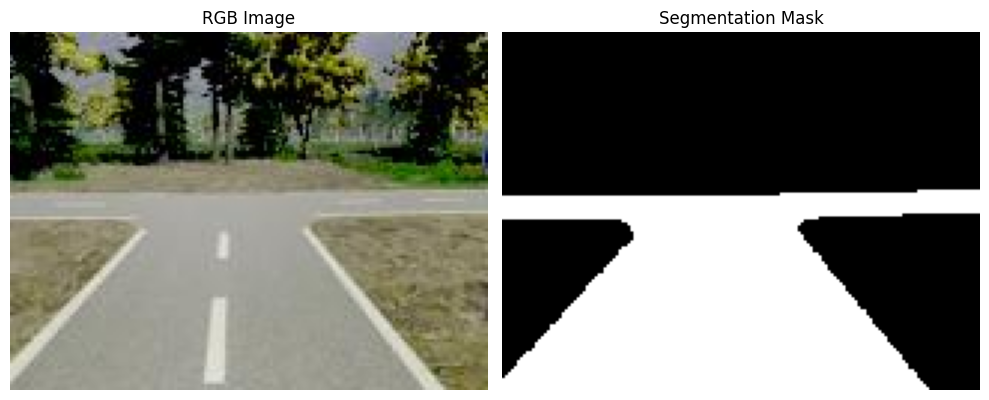

In [7]:
visualize_sample(dataset, index=100)

In [8]:
# Load DeepLabV3+ with a ResNet50 backbone
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=False)

# Modify classifier for binary segmentation (1 class + background)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)  # For binary mask


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.


In [9]:
def dice_score(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum()
    dice = 2 * intersection / (union + 1e-8)
    return dice.item()


In [10]:
def get_transforms(train=True):
    if train:
        return A.Compose([
            A.Resize(256, 256),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Normalize(mean=(0.485,0.456,0.406),
                        std=(0.229,0.224,0.225)),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(256, 256),
            A.Normalize(mean=(0.485,0.456,0.406),
                        std=(0.229,0.224,0.225)),
            ToTensorV2()
        ])


In [11]:
model = model.to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [12]:
train_ds = SegmentationDataset(folder_path="/content/CDS_2023-2/train", transform=get_transforms(train=True))
val_ds = SegmentationDataset("/content/CDS_2023-2/valid",transform=get_transforms(train=False))
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=4)

In [13]:
for epoch in range(30):
    model.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        out = model(images)['out']
        masks = masks.unsqueeze(1).float()
        loss = criterion(out, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Eval
    model.eval()
    total_dice = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            masks = masks.unsqueeze(1).float()
            pred = model(images)['out']
            total_dice += dice_score(pred, masks)
    print(f"Epoch {epoch+1}, Dice Score: {total_dice / len(val_loader):.4f}")

Epoch 1, Dice Score: 0.9797
Epoch 2, Dice Score: 0.9841
Epoch 3, Dice Score: 0.9845
Epoch 4, Dice Score: 0.9865
Epoch 5, Dice Score: 0.9857
Epoch 6, Dice Score: 0.9873
Epoch 7, Dice Score: 0.9681
Epoch 8, Dice Score: 0.9867
Epoch 9, Dice Score: 0.9863
Epoch 10, Dice Score: 0.9878
Epoch 11, Dice Score: 0.9876
Epoch 12, Dice Score: 0.9877
Epoch 13, Dice Score: 0.9881
Epoch 14, Dice Score: 0.9886
Epoch 15, Dice Score: 0.9886
Epoch 16, Dice Score: 0.9883
Epoch 17, Dice Score: 0.9873
Epoch 18, Dice Score: 0.9865
Epoch 19, Dice Score: 0.9876
Epoch 20, Dice Score: 0.9880
Epoch 21, Dice Score: 0.9873
Epoch 22, Dice Score: 0.9879
Epoch 23, Dice Score: 0.9880
Epoch 24, Dice Score: 0.9885
Epoch 25, Dice Score: 0.9866
Epoch 26, Dice Score: 0.9858
Epoch 27, Dice Score: 0.9880
Epoch 28, Dice Score: 0.9885
Epoch 29, Dice Score: 0.9883
Epoch 30, Dice Score: 0.9885


In [14]:
def unnormalize(image_tensor):
    # image_tensor shape: (H, W, C) and normalized
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    image = image_tensor * std + mean  # reverse normalization
    image = np.clip(image, 0, 1)       # clip to valid range [0,1]
    return image


def visualize_predictions(model, dataloader, device, num_samples=4):
    model.eval()
    model.to(device)
    count = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device).unsqueeze(1).float()  # make sure masks have shape (N,1,H,W)

            outputs = model(images)['out']  # model output logits, shape (N,1,H,W)
            preds = torch.sigmoid(outputs)  # apply sigmoid for binary mask probability
            preds = (preds > 0.5).float()   # threshold to get binary mask

            images = images.cpu().permute(0, 2, 3, 1).numpy()  # [N, H, W, C] RGB image
            masks = masks.cpu().squeeze(1).numpy()             # [N, H, W]
            preds = preds.cpu().squeeze(1).numpy()             # [N, H, W]

            batch_size = images.shape[0]
            for i in range(batch_size):
                if count >= num_samples:
                    return
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))

                axs[0].imshow(unnormalize(images[i]))
                axs[0].set_title("Original Image")
                axs[0].axis('off')

                axs[1].imshow(masks[i], cmap='gray')
                axs[1].set_title("Ground Truth Mask")
                axs[1].axis('off')

                axs[2].imshow(preds[i], cmap='gray')
                axs[2].set_title("Predicted Mask")
                axs[2].axis('off')

                plt.show();
                count += 1


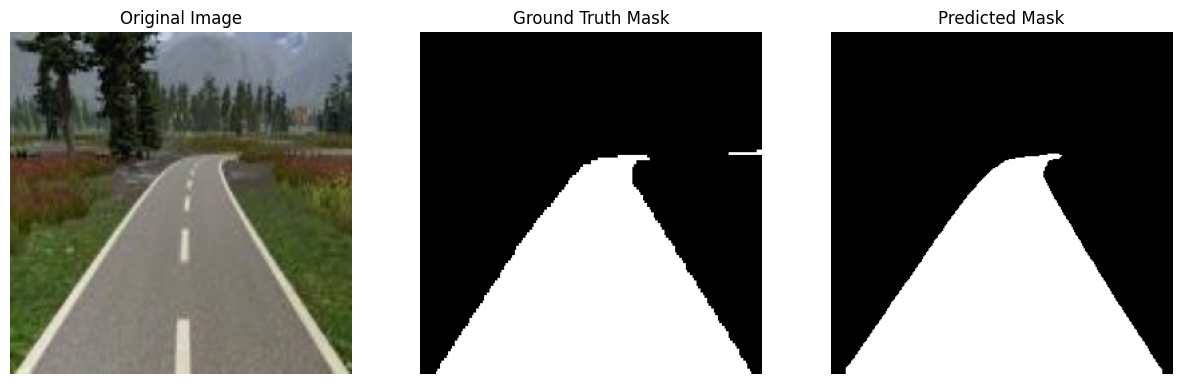

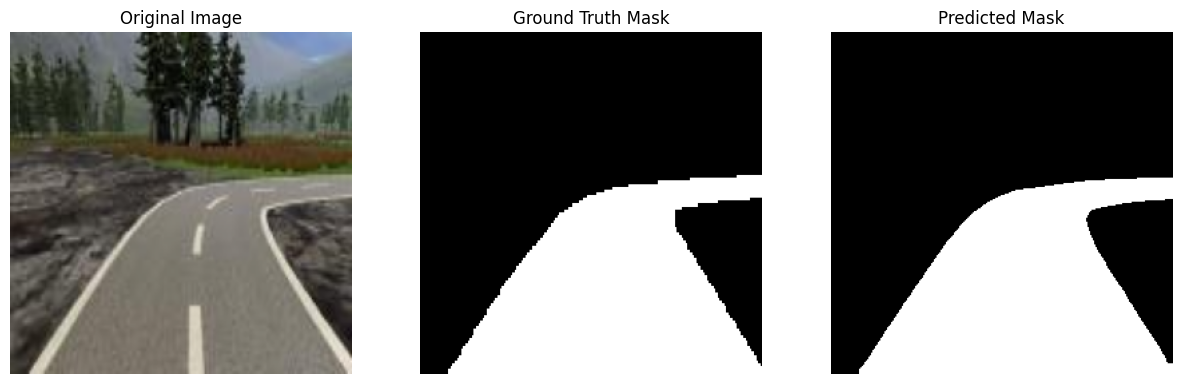

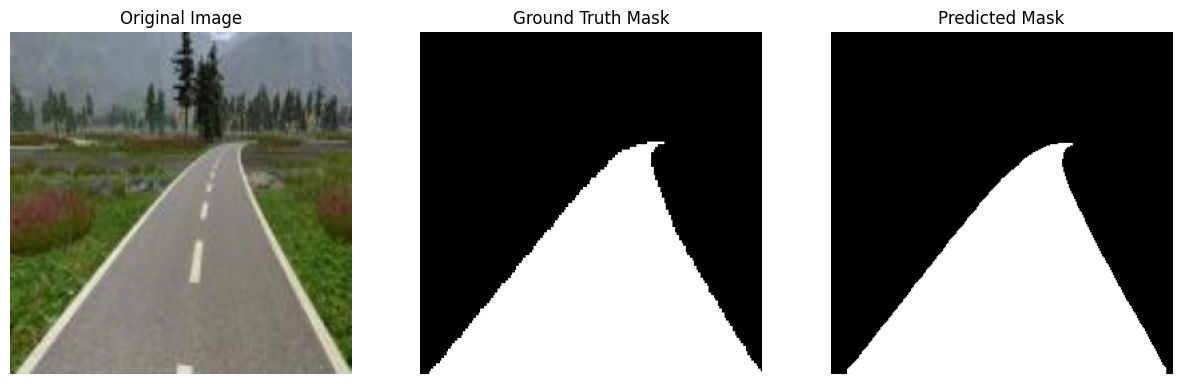

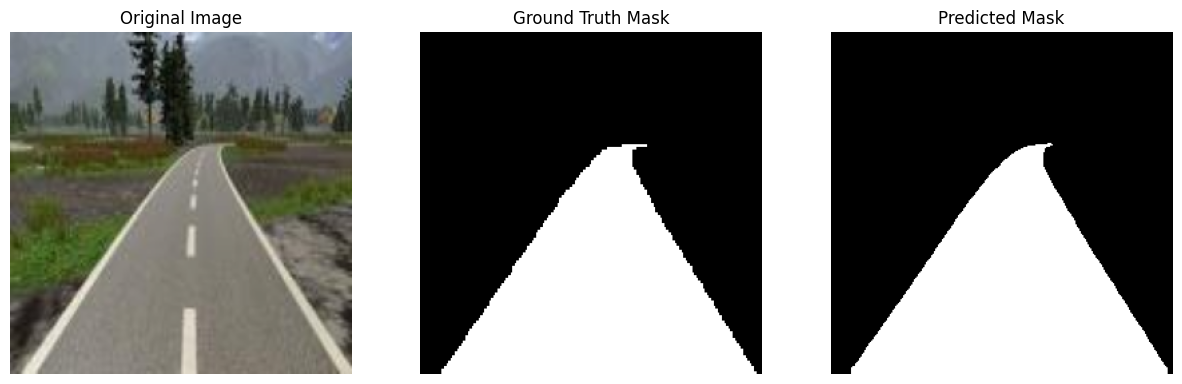

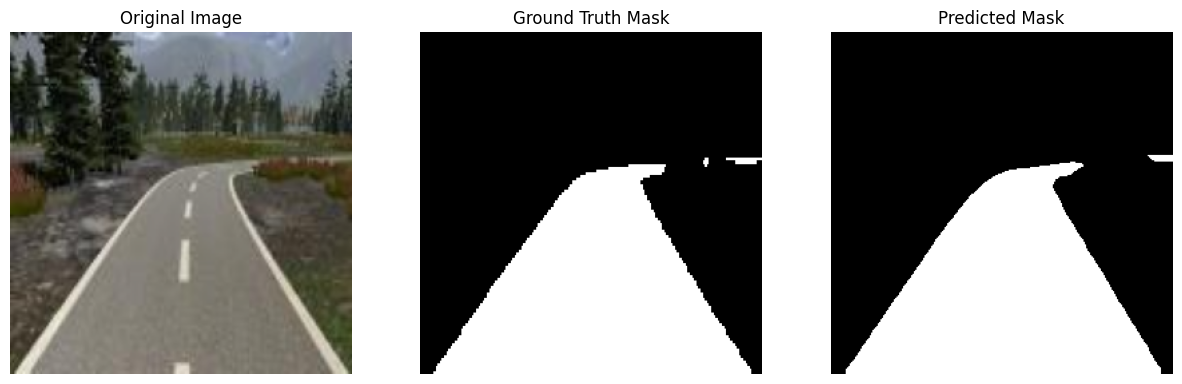

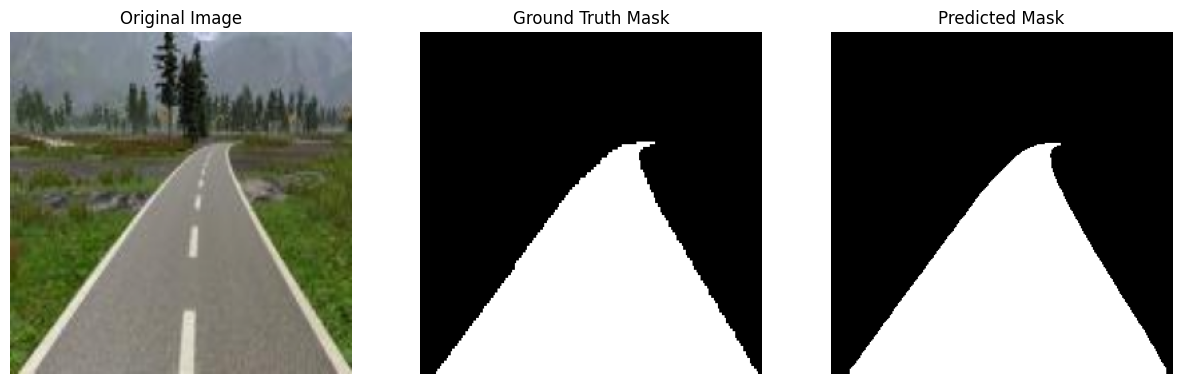

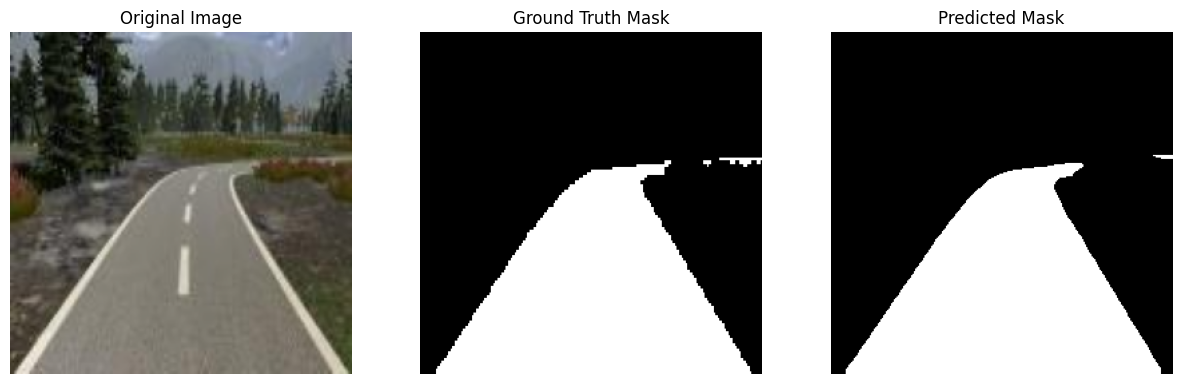

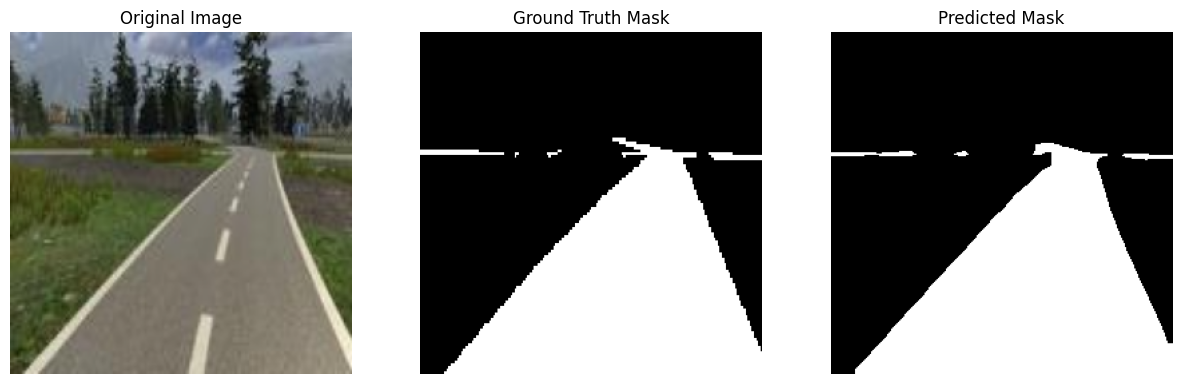

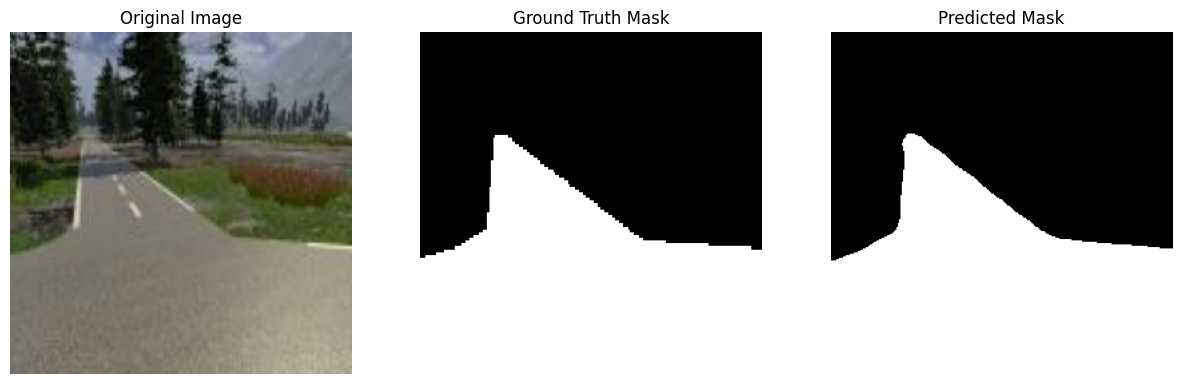

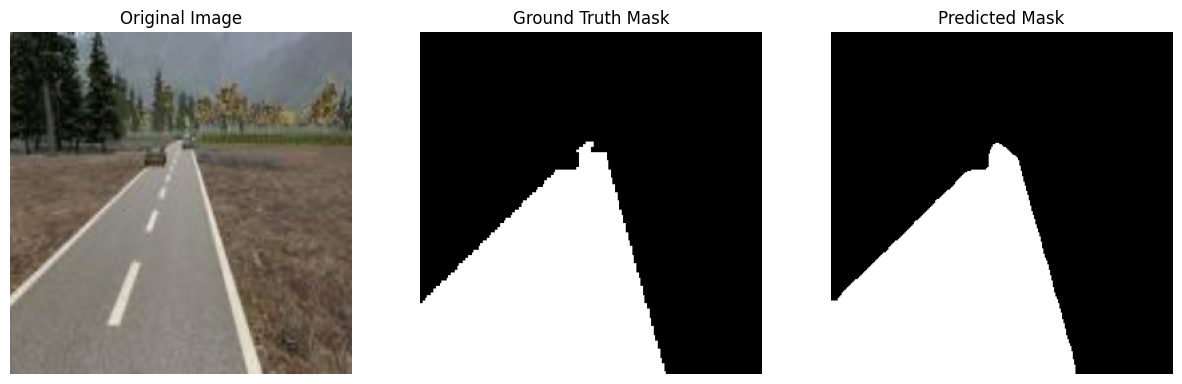

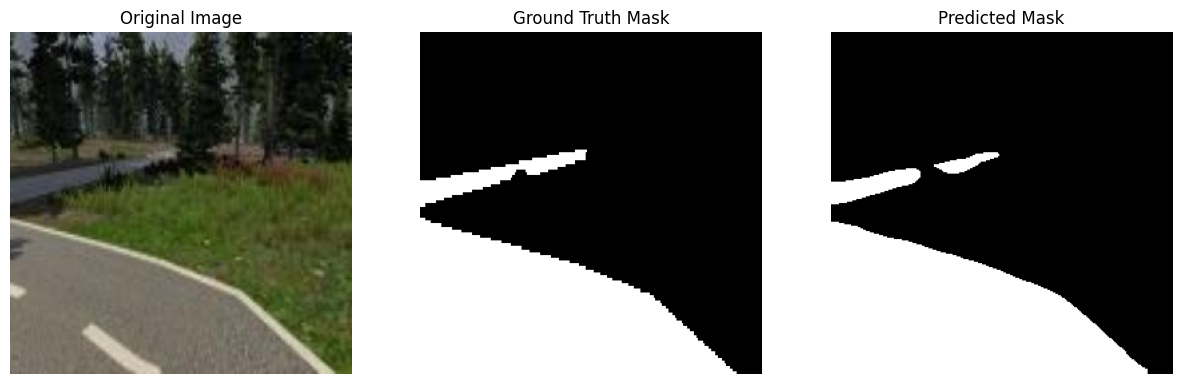

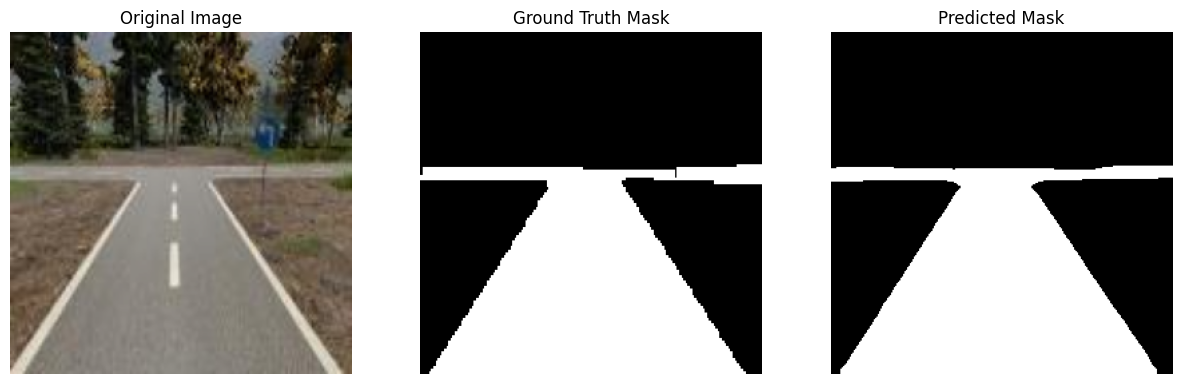

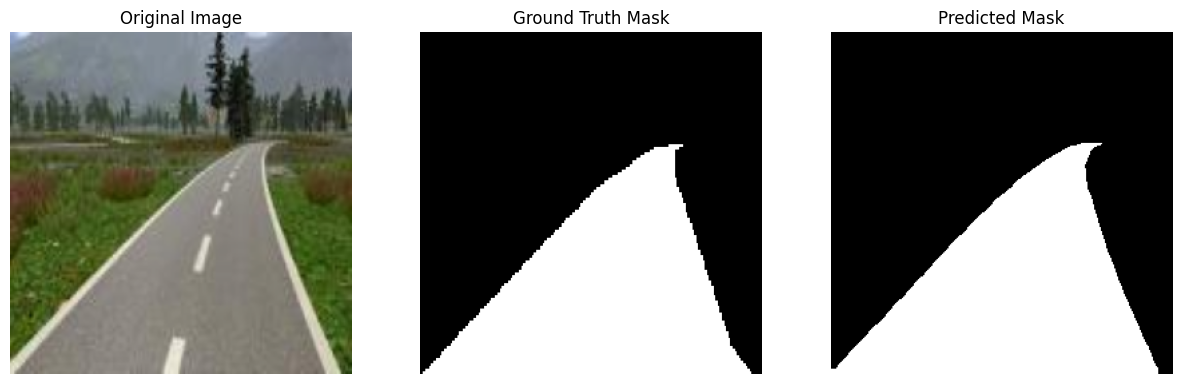

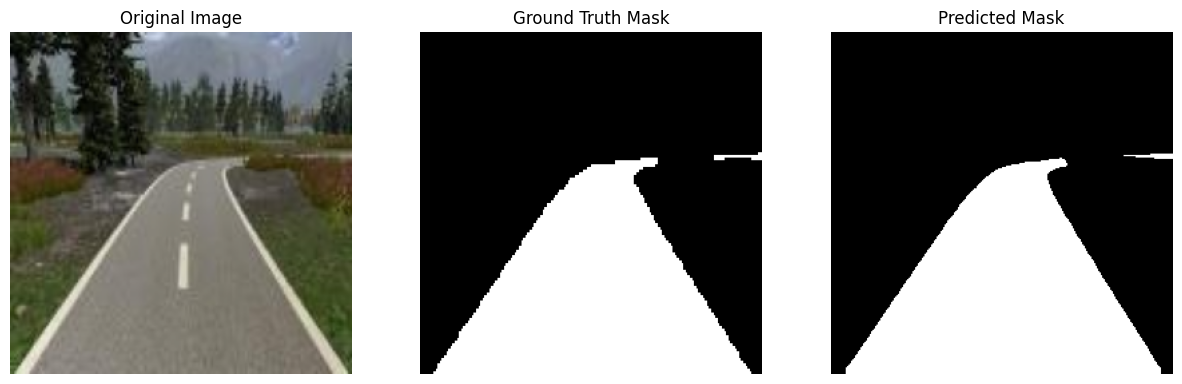

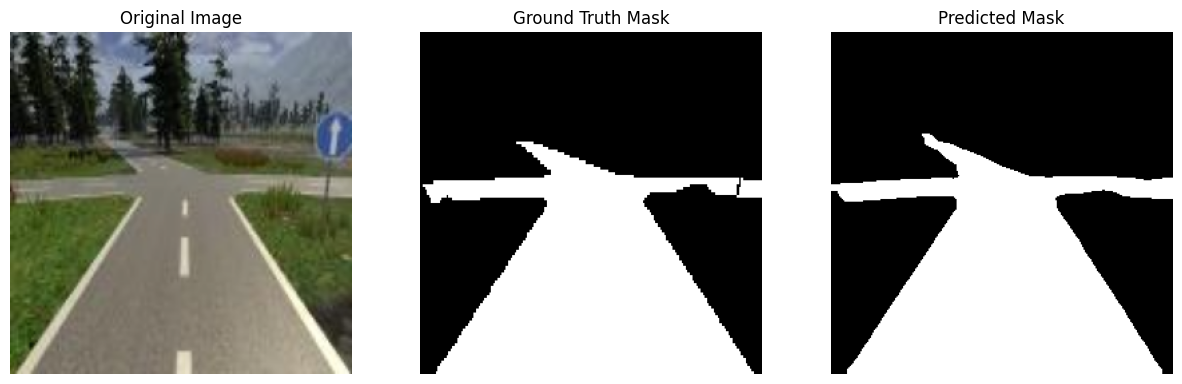

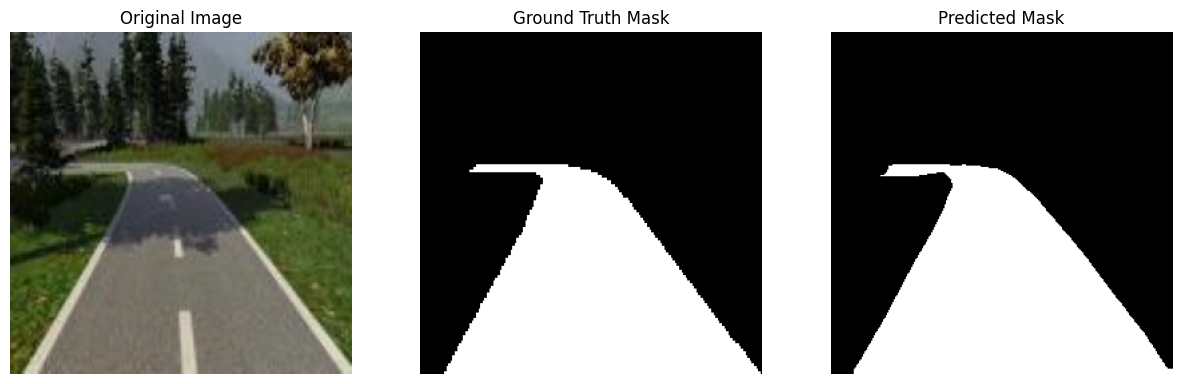

In [15]:
test_ds = SegmentationDataset(folder_path="/content/CDS_2023-2/test", transform=get_transforms(train=False))
test_loader = DataLoader(test_ds, batch_size=4, shuffle=True)

visualize_predictions(model, test_loader, device, num_samples=16)


In [16]:
torch.save(model.state_dict(), 'segmentation_model.pth')

In [17]:
# 1. Define model (same as in training)
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=False)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)  # Binary output

# 2. Load trained weights
model.load_state_dict(torch.load('/content/segmentation_model.pth', map_location=device))


model.eval()
model.to(device)

# Define preprocessing transforms (same as training but no augmentation)
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

def predict_mask(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    augmented = transform(image=image_rgb)
    input_tensor = augmented['image'].unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)['out']
        prob_mask = torch.sigmoid(output)[0, 0]
        pred_mask = (prob_mask > 0.5).cpu().numpy().astype('uint8')  # binary mask

    return image_rgb, pred_mask


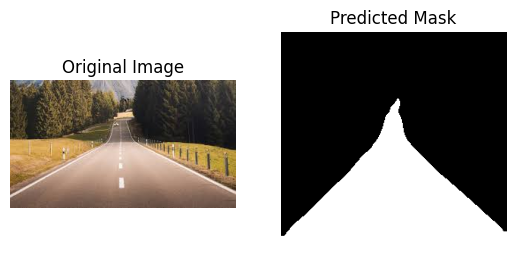

In [18]:
img, mask = predict_mask('/content/road.jpg')

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()
